In [1]:
import xml.etree.ElementTree as ET
import numpy as np
from datetime import datetime
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import joblib
import os



In [2]:
input_file = 'datasets/raw/OhioT1DM/563-ws-testing.xml'
output_file = 'datasets/processed/563-testing.csv'
root = ET.parse(input_file).getroot()



In [3]:

def parse_data(data_type):
    data = []
    if data_type in ['glucose_level', 'finger_stick', 'basal', 'basis_heart_rate', 
                        'basis_gsr', 'basis_skin_temperature', 'basis_air_temperature', 'basis_steps']:
        for event in root.findall(f'.//{data_type}/event'):
            ts_str = event.get('ts')
            ts = datetime.strptime(ts_str, '%d-%m-%Y %H:%M:%S')
            if data_type in ['basal', 'basis_gsr', 'basis_skin_temperature', 'basis_air_temperature']:
                value = float(event.get('value'))
            else:
                value = int(event.get('value'))
            data.append([np.datetime64(ts), value])
    elif data_type == 'temp_basal':
        for event in root.findall(f'.//{data_type}/event'):
            ts_begin_str = event.get('ts_begin') or event.get('tbegin')
            ts_end_str   = event.get('ts_end') or event.get('tend')
            ts_begin = datetime.strptime(ts_begin_str, '%d-%m-%Y %H:%M:%S') if ts_begin_str else None
            ts_end   = datetime.strptime(ts_end_str, '%d-%m-%Y %H:%M:%S') if ts_end_str else None
            value = float(event.get('value'))
            data.append([np.datetime64(ts_begin), np.datetime64(ts_end), value])
    elif data_type == 'bolus':
        for event in root.findall(f'.//{data_type}/event'):
            ts_begin_str = event.get('ts_begin')
            ts_end_str   = event.get('ts_end')
            ts_begin = datetime.strptime(ts_begin_str, '%d-%m-%Y %H:%M:%S')
            ts_end   = datetime.strptime(ts_end_str, '%d-%m-%Y %H:%M:%S')
            dose = float(event.get('dose'))
            data.append([np.datetime64(ts_begin), np.datetime64(ts_end), dose])
    elif data_type == 'meal':
        for event in root.findall(f'.//{data_type}/event'):
            ts_str = event.get('ts')
            ts = datetime.strptime(ts_str, '%d-%m-%Y %H:%M:%S')
            meal_type = event.get('type')
            carbs = int(event.get('carbs'))
            data.append([np.datetime64(ts), meal_type, carbs])
    elif data_type == 'exercise':
        for event in root.findall(f'.//{data_type}/event'):
            ts_str = event.get('ts')
            ts = datetime.strptime(ts_str, '%d-%m-%Y %H:%M:%S')
            intensity = int(event.get('intensity'))
            duration = int(event.get('duration'))  # duration in minutes
            ts_end = ts + timedelta(minutes=duration)
            data.append([np.datetime64(ts), np.datetime64(ts_end), intensity])
    return np.array(data)

# Function to perform asof merge for a given measurement DataFrame.
def merge_measurement(df_perfect, df_meas, meas_col):
    # Backward merge: the most recent measurement not after the perfect timestamp.
    df_merge = pd.merge_asof(
        df_perfect,
        df_meas.rename(columns={'timestamp': 'prev_timestamp', meas_col: f'{meas_col}_value'}),
        left_on='perfect_timestamp',
        right_on='prev_timestamp',
        direction='backward'
    )
    # Forward merge: the earliest measurement not before the perfect timestamp.
    df_merge = pd.merge_asof(
        df_merge,
        df_meas.rename(columns={'timestamp': 'next_timestamp', meas_col: f'{meas_col}_value_next'}),
        left_on='perfect_timestamp',
        right_on='next_timestamp',
        direction='forward'
    )
    return df_merge

# Modified threshold in minutes
THRESHOLD = 5

# Function to choose the closest measurement timestamp and compute time difference in minutes.
def choose_nearest(row):
    pt = row['perfect_timestamp']
    prev = row.get('prev_timestamp', pd.NaT)
    nxt = row.get('next_timestamp', pd.NaT)
    
    # Both missing.
    if pd.isna(prev) and pd.isna(nxt):
        return pd.NaT, np.nan
    # Only previous exists.
    elif pd.isna(nxt):
        diff = (pt - prev).total_seconds() / 60.0
        if diff < THRESHOLD:
            return prev, diff
        else:
            return pd.NaT, np.nan
    # Only next exists.
    elif pd.isna(prev):
        diff = (nxt - pt).total_seconds() / 60.0
        if diff < THRESHOLD:
            return nxt, diff
        else:
            return pd.NaT, np.nan
    else:
        diff_prev = (pt - prev).total_seconds() / 60.0
        diff_next = (nxt - pt).total_seconds() / 60.0
        if diff_prev <= diff_next and diff_prev < THRESHOLD:
            return prev, diff_prev
        elif diff_next < THRESHOLD:
            return nxt, diff_next
        else:
            return pd.NaT, np.nan

# Function to choose the measurement value based on the nearest valid timestamp.
def choose_value(row, meas_col):
    pt = row['perfect_timestamp']
    prev = row.get('prev_timestamp', pd.NaT)
    nxt = row.get('next_timestamp', pd.NaT)
    
    # Both missing.
    if pd.isna(prev) and pd.isna(nxt):
        return np.nan
    # Only previous exists.
    elif pd.isna(nxt):
        diff = (pt - prev).total_seconds() / 60.0
        if diff < THRESHOLD:
            return row[f'{meas_col}_value']
        else:
            return np.nan
    # Only next exists.
    elif pd.isna(prev):
        diff = (nxt - pt).total_seconds() / 60.0
        if diff < THRESHOLD:
            return row[f'{meas_col}_value_next']
        else:
            return np.nan
    else:
        diff_prev = (pt - prev).total_seconds() / 60.0
        diff_next = (nxt - pt).total_seconds() / 60.0
        if diff_prev <= diff_next and diff_prev < THRESHOLD:
            return row[f'{meas_col}_value']
        elif diff_next < THRESHOLD:
            return row[f'{meas_col}_value_next']
        else:
            return np.nan

def compute_iob(df, DOA_hours=5, interval_min=5):
    """
    Compute the Insulin On Board (IOB) for each row of the DataFrame.
    
    Parameters:
        df (pd.DataFrame): DataFrame with columns 'real_basal' (in U/hr) and 'bolus' (in U).
        DOA_hours (float): Duration of insulin action in hours.
        interval_min (float): Time difference between consecutive rows in minutes.
    
    Returns:
        pd.DataFrame: A new DataFrame with an added 'IOB' column.
    """
    # Convert time step to hours
    interval_hr = interval_min / 60.0
    
    # Determine the number of time steps for the duration of insulin action (DOA)
    decay_steps = int(DOA_hours / interval_hr)
    
    # Define a quadratic decay curve (from 1 at time=0 to 0 at time=DOA)
    t = np.linspace(0, 1, decay_steps)
    decay = 1 - (t**2) * (3 - 2*t)  # smooth quadratic decay
    
    # Convert the basal rate (U/hr) to basal amount (U) delivered in each interval
    basal_amt = df['real_basal'] * interval_hr
    
    # Use convolution to compute the cumulative effect of past boluses and basal doses
    # The convolution automatically sums the contributions from previous time steps weighted by decay.
    bolus_contrib = np.convolve(df['bolus'], decay, mode='full')[:len(df)]
    basal_contrib = np.convolve(basal_amt, decay, mode='full')[:len(df)]
    
    # Create a copy of the original DataFrame and add the IOB column
    df_out = df.copy()
    df_out['IOB'] = bolus_contrib + basal_contrib
    
    return df_out

def compute_tia(df, DOA_hours=3, interval_min=5):
    """
    Compute the Total Insulin Action (TIA) for each row of the DataFrame.
    
    Parameters:
        df (pd.DataFrame): DataFrame with columns 'real_basal' (in U/hr) and 'bolus' (in U).
        DOA_hours (float): Duration of insulin action in hours (how long a bolus affects TIA).
        interval_min (float): Time difference between consecutive rows in minutes.
    
    Returns:
        pd.DataFrame: A new DataFrame with added 'TIA' column (U/hr).
    """
    # Convert time step to hours
    interval_hr = interval_min / 60.0
    
    # Number of steps for insulin decay
    decay_steps = int(DOA_hours / interval_hr)
    
    # Define decay curve (quadratic) and normalize to sum=1
    t = np.linspace(0, 1, decay_steps)
    decay = 1 - (t**2) * (3 - 2*t)  # Quadratic decay from 1 to 0
    decay /= decay.sum()  # Normalize so total decayed bolus = original amount
    
    # Compute bolus contributions over time using convolution
    bolus_contrib = np.convolve(df['bolus'], decay, mode='full')[:len(df)]
    
    # Convert bolus contribution to U/hr (since interval is in minutes)
    bolus_contrib_hr = bolus_contrib / (interval_min / 60)
    
    # Total Insulin Action = Basal (U/hr) + Bolus Contribution (U/hr)
    df_out = df.copy()
    df_out['TIA'] = df['real_basal'] + bolus_contrib_hr
    
    return df_out

def tia_action(df, tia_col='TIA', action_col='action', eta=4.0, I_max=5.0):
    """
    Convert Total Insulin Action (TIA) column to action values `a` ∈ [-1, 1] in a DataFrame.
    
    Parameters:
        df (pd.DataFrame): Input DataFrame containing TIA values
        tia_col (str): Name of column containing Total Insulin Action (U/hr)
        action_col (str): Name of output column to store actions
        eta (float): Scaling parameter (default=4.0)
        I_max (float): Maximum insulin rate in U/min (default=5.0)
        
    Returns:
        pd.DataFrame: DataFrame with added action column
    
    Example:
        df = tia_action(df, tia_col='TIA', action_col='a')
    """
    # Convert TIA (U/hr) to insulin pump rate (U/min)
    I_pump = df[tia_col] / 60  # Convert U/hr to U/min
    
    # Clip to valid range [0, I_max] to avoid numerical issues
    I_pump = np.clip(I_pump, 1e-9, I_max)  # Small positive value to avoid log(0)
    
    # Compute action using the pump equation
    df[action_col] = 1 + (1/eta) * np.log(I_pump/I_max)
    
    # Clip final actions to [-1, 1] range
    df[action_col] = np.clip(df[action_col], -1, 1)
    
    return df

In [4]:


glucose_level = parse_data('glucose_level') # continuous data
finger_stick = parse_data('finger_stick') #sparse data
basal = parse_data('basal') #sparse data 
basis_heart_rate = parse_data('basis_heart_rate') #continuous data
basis_gsr = parse_data('basis_gsr') #continuous data
basis_skin_temperature = parse_data('basis_skin_temperature') #continuous data
basis_air_temperature = parse_data('basis_air_temperature') #continuous data
basis_steps = parse_data('basis_steps') #continuous data
temp_basal = parse_data('temp_basal') #Tb #Te #dose
bolus = parse_data('bolus') #Tb #Te #dose #carb_input



In [5]:
measurements = {
    'glucose_level': glucose_level,
    'finger_stick': finger_stick,
    'basal': basal,
    'basis_heart_rate': basis_heart_rate,
    'basis_gsr': basis_gsr,
    'basis_skin_temperature': basis_skin_temperature,
    'basis_air_temperature': basis_air_temperature,
    'basis_steps': basis_steps
}

# Convert each measurement array to a DataFrame with proper datetime conversion.
dfs = {}
global_min = None
global_max = None

for name, arr in measurements.items():
    df = pd.DataFrame(arr, columns=['timestamp', name])
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.sort_values('timestamp').reset_index(drop=True)
    dfs[name] = df
    
    # Update the global min and max timestamps.
    current_min = df['timestamp'].min()
    current_max = df['timestamp'].max()
    if global_min is None or current_min < global_min:
        global_min = current_min
    if global_max is None or current_max > global_max:
        global_max = current_max

# Force the global start to midnight.
global_start = global_min.normalize()
global_end = global_max

# Create a perfect timestamp index with a 5-minute frequency over the full range.
perfect_index = pd.date_range(start=global_start, end=global_end, freq='5min')
df_perfect = pd.DataFrame({'perfect_timestamp': perfect_index})



# Start with the perfect index DataFrame and then add new columns for each measurement.
df_final = df_perfect.copy()

for meas, df_meas in dfs.items():
    # Merge the measurement into the perfect index.
    df_merge = merge_measurement(df_final[['perfect_timestamp']], df_meas, meas)
    
    # Apply the function to choose the nearest timestamp and compute the time difference.
    res = df_merge.apply(lambda row: pd.Series(choose_nearest(row)), axis=1)
    df_merge[f'{meas}_associated_timestamp'] = res.iloc[:, 0]
    df_merge[f'{meas}_time_diff_min'] = res.iloc[:, 1]
    
    # Choose the measurement value using the threshold condition.
    df_merge[f'{meas}_final'] = df_merge.apply(lambda row: choose_value(row, meas), axis=1)
    
    # Add the measurement columns to the final DataFrame.
    df_final[meas] = df_merge[f'{meas}_final']
    df_final[f'{meas}_time_diff_min'] = df_merge[f'{meas}_time_diff_min']


# Forward fill the basal values.
df_final['basal'] = df_final['basal'].ffill()
# Backward fill the basal values (for the first few rows).
df_final['basal'] = df_final['basal'].bfill()

In [6]:

# Create the real_basal column as a copy of the forward-filled basal values.
df_final['real_basal'] = df_final['basal'].copy()

# For each temp_basal episode, overwrite real_basal in that time interval.
for row in temp_basal:
    t_start = pd.to_datetime(row[0])
    t_end   = pd.to_datetime(row[1])
    val     = row[2]
    mask = (df_final['perfect_timestamp'] >= t_start) & (df_final['perfect_timestamp'] <= t_end)
    df_final.loc[mask, 'real_basal'] = val


df_final['bolus'] = 0.0

# Process each bolus entry.
for row in bolus:
    t_beg = pd.to_datetime(row[0])
    t_end = pd.to_datetime(row[1])
    dose  = float(row[2])
    
    if t_beg == t_end:
        # Single data point: find the perfect timestamp that is closest.
        diffs = (df_final['perfect_timestamp'] - t_beg).abs()
        idx = diffs.idxmin()
        # Optionally, you can decide to only assign if the closest point is within a threshold.
        df_final.loc[idx, 'bolus'] += dose
    else:
        # Distributed bolus: find all perfect timestamps in the interval.
        mask = (df_final['perfect_timestamp'] >= t_beg) & (df_final['perfect_timestamp'] <= t_end)
        count = mask.sum()
        if count > 0:
            distributed = dose / count
            df_final.loc[mask, 'bolus'] += distributed



In [7]:

df_with_iob = compute_iob(df_final)
df_with_tia = compute_tia(df_with_iob)
df_with_actions = tia_action(df_with_tia)
df= df_with_actions.drop(columns=['glucose_level_time_diff_min','finger_stick', 'finger_stick_time_diff_min', 'basal',
       'basal_time_diff_min', 'basis_heart_rate_time_diff_min', 'basis_gsr',
       'basis_gsr_time_diff_min', 'basis_skin_temperature','basis_skin_temperature_time_diff_min',
       'basis_air_temperature','basis_air_temperature_time_diff_min', 'basis_steps','basis_steps_time_diff_min'],inplace=False)

In [8]:
# Derivatives
df['glucose_derivative'] = df['glucose_level'].diff()/5  # Difference from previous
df['heart_rate_derivative'] = df['basis_heart_rate'].diff()/5

# Function to calculate trend (slope over last 30 mins = 6 points)
def compute_trend(series, window=6):
    trend = []
    for i in range(len(series)):
        if i < window - 1 or series[i - window + 1:i + 1].isna().any():
            trend.append(np.nan)
        else:
            y = series[i - window + 1:i + 1].values.reshape(-1, 1)
            x = np.arange(window).reshape(-1, 1)
            model = LinearRegression().fit(x, y)
            trend.append(model.coef_[0][0])
    return trend


# Trend columns
df['glucose_trend'] = compute_trend(df['glucose_level'])
df['heart_rate_trend'] = compute_trend(df['basis_heart_rate'])




In [ ]:
#basal_min, basal_max = 0.0, 2.0  # Example: Basal ranges from 0 to 2 U/hr
#bolus_min, bolus_max = 0.0, 25.0   # Example: Bolus ranges from 0 to 25 U
#df["basal"] = (df["basal"] - basal_min) / (basal_max - basal_min) * 2 - 1
#df["bolus"] = (df["bolus"] - bolus_min) / (bolus_max - bolus_min) * 2 - 1

In [9]:
df.rename(columns={
    "perfect_timestamp":   "time",
    "glucose_level":       "glu",
    "basis_heart_rate":    "hr",
    "real_basal":          "basal",
    "IOB":                 "iob",
    "TIA":                 "tia",
    "glucose_derivative":  "glu_d",
    "heart_rate_derivative": "hr_d",
    "glucose_trend":       "glu_t",
    "heart_rate_trend":    "hr_t"
}, inplace=True)

df["glu_raw"] = df["glu"]

features_to_normalize = [
    "glu", "glu_d", "glu_t",
    "hr",  "hr_d",  "hr_t", "iob"]



In [ ]:

scaler = StandardScaler()
df[features_to_normalize] = scaler.fit_transform(df[features_to_normalize])
joblib.dump(scaler,'scaler.pkl')


In [10]:


scaler = joblib.load('scaler.pkl')
df[features_to_normalize] = scaler.fit_transform(df[features_to_normalize])



In [11]:

# Add hour and hour_norm
df["hour_day"] = pd.to_datetime(df["time"]).dt.hour
df["hour"] = df["hour_day"] / 24.0

# Define episodes by day (daily episodes)
df["day"] = pd.to_datetime(df["time"]).dt.date
df["done"] = (df["day"] != df["day"].shift(-1)).astype(int)

# Drop helper columns if needed
df.drop(columns=["hour_day", "day"], inplace=True)

# Reorder columns
ordered_columns = [
    "time", # Optional timestamp for reference
    "glu_raw",            
    "glu", "glu_d", "glu_t",
    "hr", "hr_d", "hr_t",
    "iob", "hour",  # <- state features
    "basal", "bolus", "tia",    # <- clarification features
    "action",  # <- action feature
    "done"     # <- episode boundary flag
]

df = df[ordered_columns]




In [12]:

df.to_csv(output_file, index=False)





In [1]:
from data_curation import*

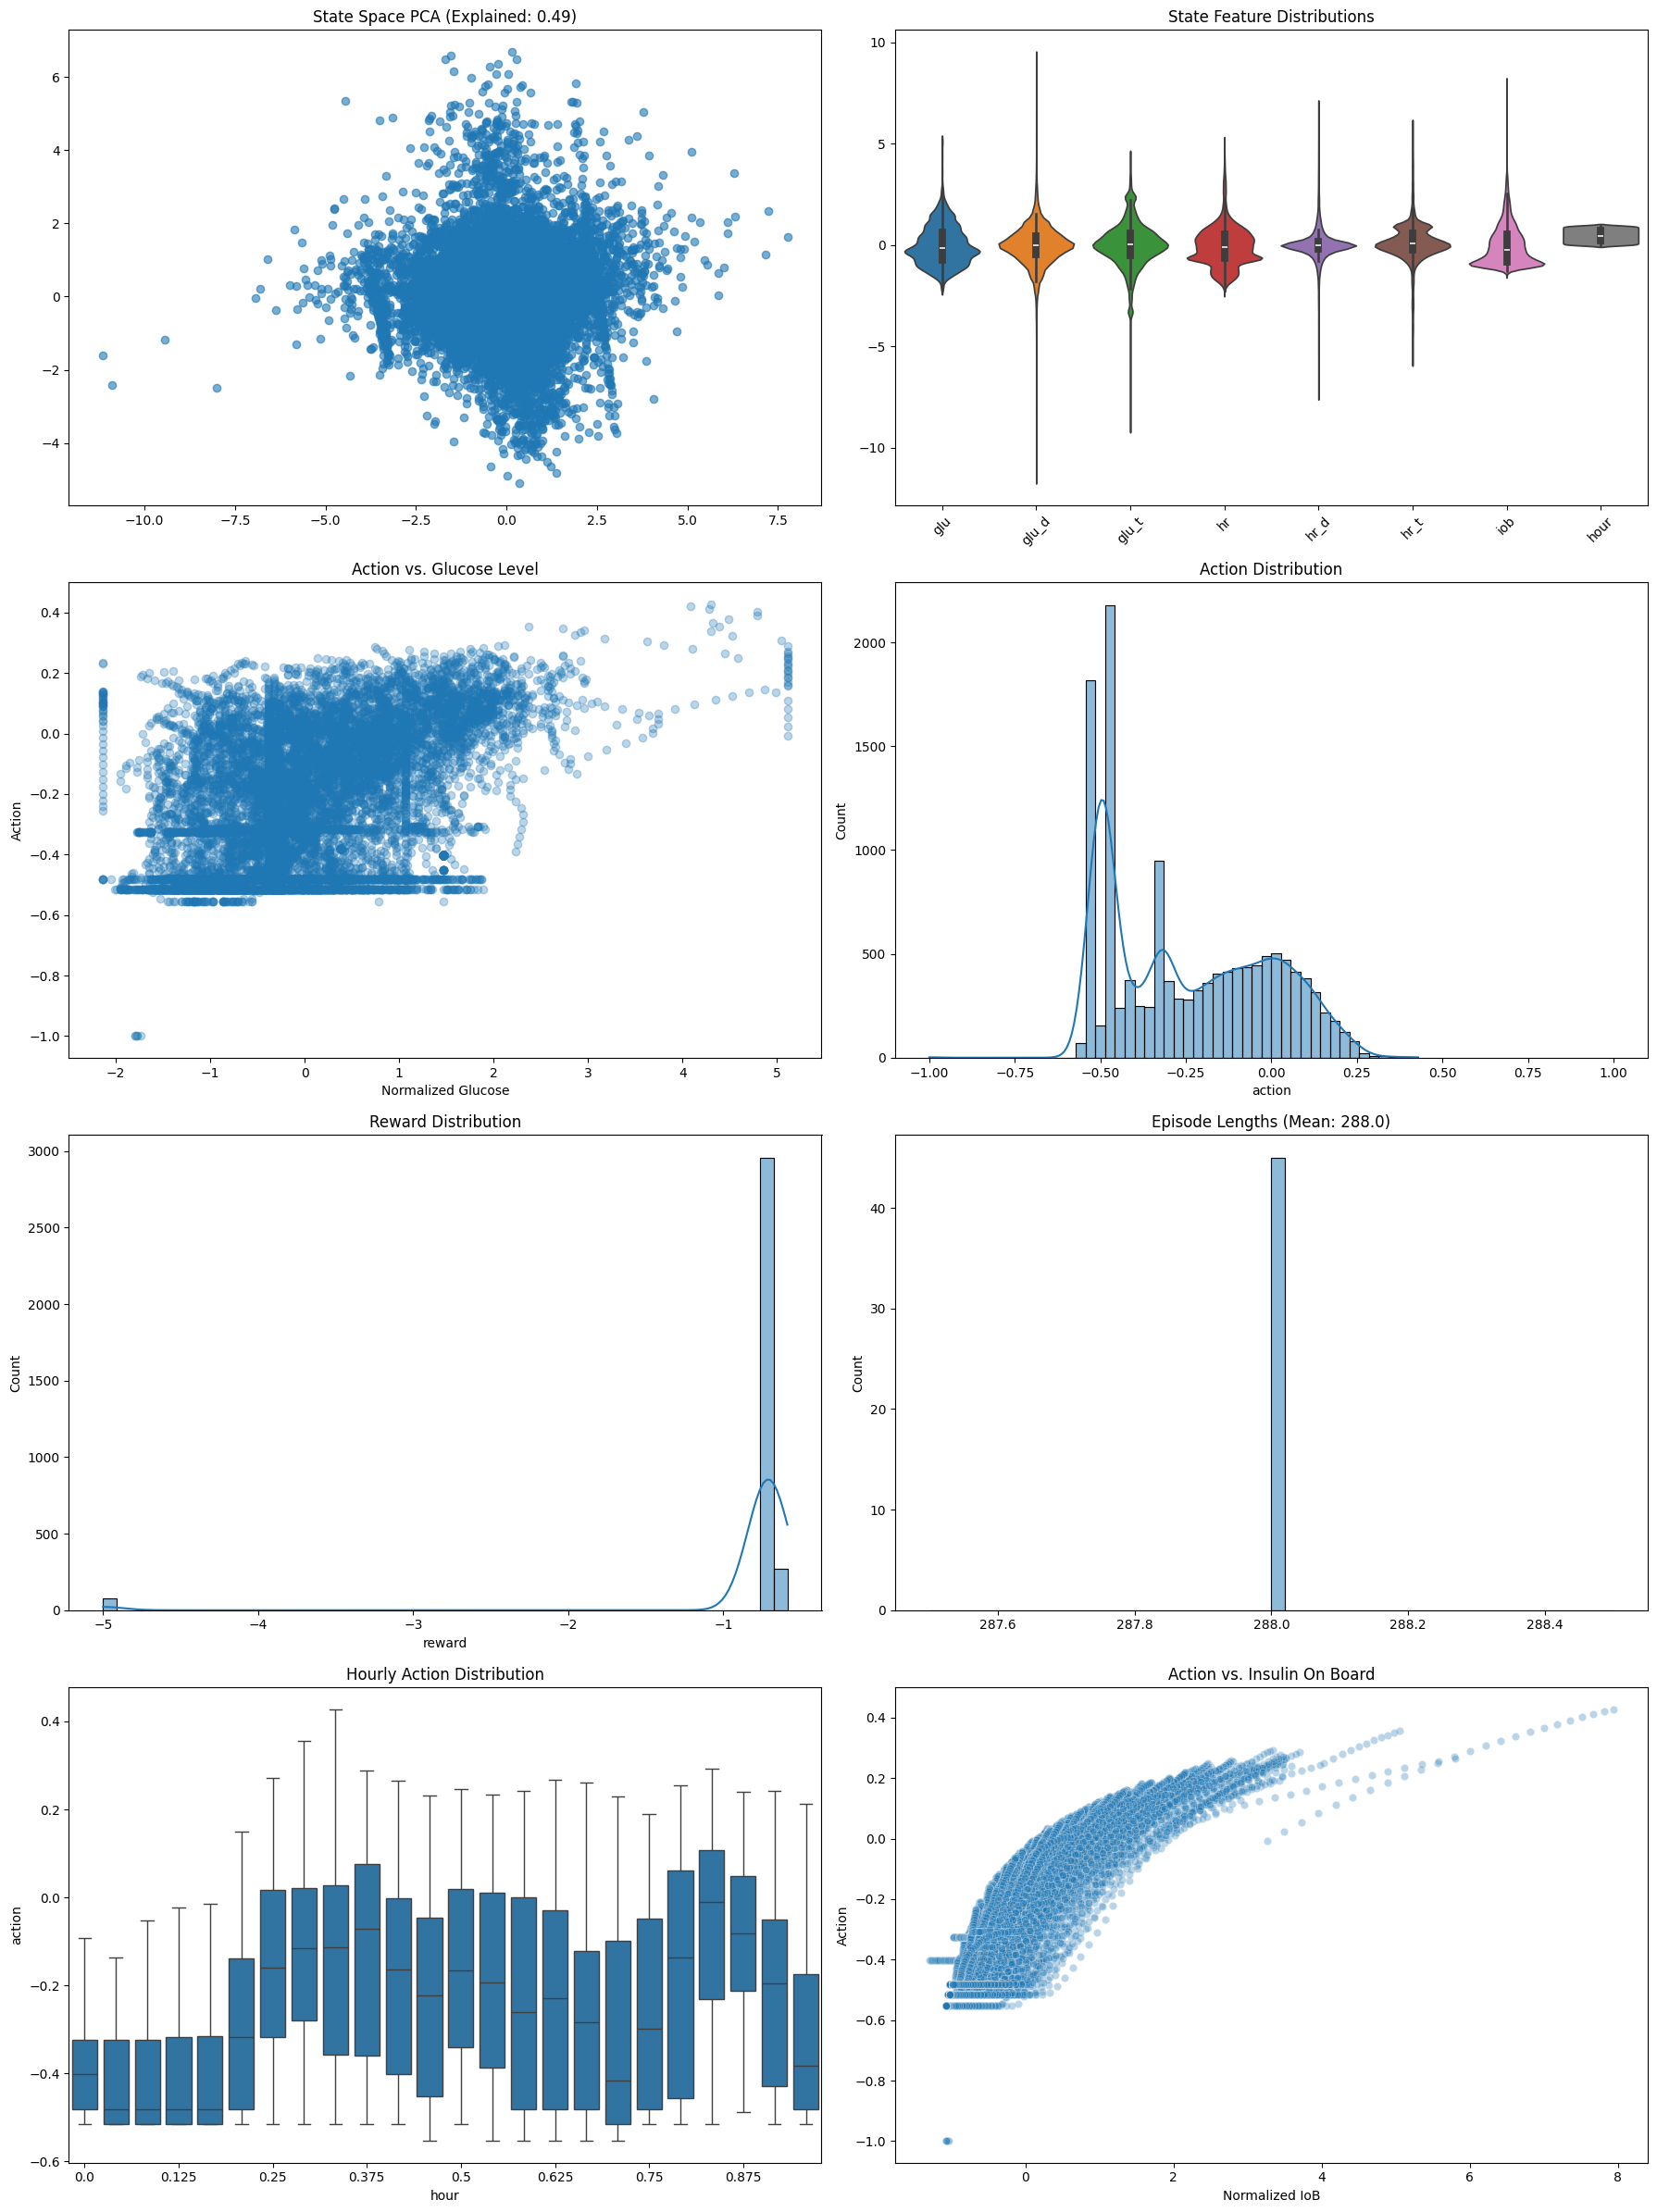


=== Critical Metrics ===

Action Space Statistics:
                  0
min       -1.000000
max        0.428152
mean      -0.241645
std        0.232293
5th %ile  -0.515114
95th %ile  0.140078

Top State-Action Correlations:
action    1.000000
iob       0.879694
glu       0.468684
hour      0.212802
hr        0.143449
Name: action, dtype: float64

Episodes with Extreme Actions (<-0.9): 0.04%
Episodes with No Action (>-0.1): 32.65%

Weakest Hourly Coverage: 551 samples

Missing States: 0
Missing Actions: 0


In [2]:
dataset = DiabetesDataset("datasets/processed/563-training.csv")
evaluate_dataset_coverage(dataset, n_samples=2000)